# TIME SERIES ANALYSIS - STORE SALES ANALYSIS AND PREDICTION

## PROJECT DESCRIPTION
A time series refers to a sequence of data points collected and recorded chronologically over time. It involves the observation of a particular variable or set of variables at regular or irregular intervals. Time series data can be generated from various sources, such as stock prices, weather conditions, population statistics, economic indicators, or sensor readings. In this project, you'll predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer.

To achieve our goal, we will employ a combination of statistical techniques and machine learning algorithms specifically designed for time series analysis.

By leveraging these analytical tools, we aim to make accurate predictions and provide valuable insights into the future behaviour of the time series. The outcomes of this project will not only enhance our understanding of the underlying dynamics of the dataset but also enable us to make informed decisions and formulate effective strategies based on the predicted values.

The project will follow a systematic approach, encompassing data preprocessing, exploratory data analysis, model selection, parameter tuning, and evaluation. Throughout the process, we will adhere to the industry-standard methodology, the CRISP-DM framework, to ensure a structured and reliable analysis.

By the end of this project, we anticipate obtaining robust and reliable forecasting models that can be applied to future time periods, enabling us to make data-driven decisions, optimize resource allocation, and achieve improved performance in the relevant domain.

## HYPOTHESIS AND QUESTIONS:

Null Hypothesis: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternate Hypothesis: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

1. Which Month had the lowest and highest sales for each year?
2. Which 5 Cities had the highest and lowest sales for each year
3. Which year had the highest and lowest transactions made?
4. Which store has the highest average sales, and which one has the lowest for each year?
5. What is the relationship between oil prices and store sales? 
6. What are the top 5 products which had the highest and lowest sales?

## Install Important Packages

In [2]:
# Data Handling tools
import numpy as np
import pandas as pd
from scipy import stats
import pyodbc
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import warnings

# Machine Learning tools
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm 

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.metrics import mean_squared_error, mean_squared_log_error

warnings.filterwarnings('ignore')

### Data Loading
Here is the section to load the datasets

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Construct the connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


In [4]:
connection=pyodbc.connect(connection_string)

In [5]:
query1 = "Select * from dbo.holidays_events"
df_holi = pd.read_sql(query1,connection)

query2 = "Select * from dbo.oil"
df_oil = pd.read_sql(query2,connection)

query3 = "Select * from dbo.stores"
df_stores = pd.read_sql(query3,connection)

df_trans= pd.read_csv('transactions.csv')

df_train= pd.read_csv('train.csv')

df_ss= pd.read_csv('sample_submission.csv')

df_test= pd.read_csv('test.csv')

#### DATA OVERVIEW

We were provided with 7 datasets which we shall be analysing namely

1. Transactions
2. Train
3. Test
4. Sample submission
5. Stores
6. Holiday
7. Oil

First and foremost we would like to check their shapes to see if they have equal Columns

#### 1. Transactions

In [6]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [7]:
df_trans.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

#### 2. Train

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [9]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

#### 3. Test

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [11]:
df_test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

#### 4. Sample Submission

In [12]:
df_ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [13]:
df_ss.isnull().sum()

id       0
sales    0
dtype: int64

#### 5. Stores

In [14]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [15]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

#### 6. Holiday

In [16]:
df_holi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [17]:
df_holi.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

#### 7. Oil

In [18]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [19]:
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [20]:
df_oil['dcoilwtico'].fillna(method='backfill',inplace=True)
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

#### Converting the 'date' column in the datasets to datetime format

In [21]:
# Train dataset
df_train['date'] = pd.to_datetime(df_train['date'])

# Test dataset
df_test['date'] = pd.to_datetime(df_test['date'])

# Holiday Events dataset
df_holi['date'] = pd.to_datetime(df_holi['date'])

# Oil dataset
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Transactions dataset
df_trans['date'] = pd.to_datetime(df_trans['date'])

#### Checking completeness of train dataset

In [22]:
# Check the completeness of the train dataset
min_date = df_train['date'].min()
max_date = df_train['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(df_train['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [23]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
df_train = pd.concat([df_train, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
df_train.sort_values('date', inplace=True)

In [24]:
# Check the completeness of the train dataset
min_date = df_train['date'].min()
max_date = df_train['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(df_train['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000892 entries, 0 to 2999554
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           float64       
 1   date         datetime64[ns]
 2   store_nbr    float64       
 3   family       object        
 4   sales        float64       
 5   onpromotion  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 160.3+ MB


In [26]:
df_train.isnull().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

### Combine all the data to One data

In [27]:
# Merge train_df with stores_df on 'store_nbr' column
merged_df1 = df_train.merge(df_stores, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(df_trans, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df on 'date' column
merged_df3 = merged_df2.merge(df_holi, on='date', how='inner')

# Merge merged_df3 with oil_df on 'date' column
finaldata = merged_df3.merge(df_oil, on='date', how='inner')

# View the first five rows of the merged dataset
finaldata.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


#### Rechecking that the data is complete

In [28]:
# Check the completeness of the train dataset
min_date = finaldata['date'].min()
max_date = finaldata['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(df_train['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


In [29]:
finaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  float64       
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  float64       
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  float64       
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [30]:
finaldata.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type_x          0
cluster         0
transactions    0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [31]:
# Renaming the columns with the approapriate names
finaldata = finaldata.rename(columns={"type_x": "store_type", "type_y": "holiday_type","dcoilwtico":"oil_price" })
finaldata.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,oil_price
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [32]:
finaldata.duplicated().sum()

0

In [33]:
finaldata.to_csv(r'C:\Users\Admin\Desktop\tseries\finaldata.csv', index=False, header=True)

## EXPLORATORY DATA ANALYSIS

In [34]:
# Create a copy of the original data to avoid data spoilage during EDA
finaledadata = finaldata.copy()

#### Univariate Analyses

Sales
Transactions
oil
holiday
promotions

##### 1. Sales

In [35]:
finaledadata['sales'].describe()

count    322047.000000
mean        406.383452
std        1246.881240
min           0.000000
25%           1.000000
50%          19.000000
75%         241.260505
max      124717.000000
Name: sales, dtype: float64

Text(0.5, 1.0, 'Distribution of Sales')

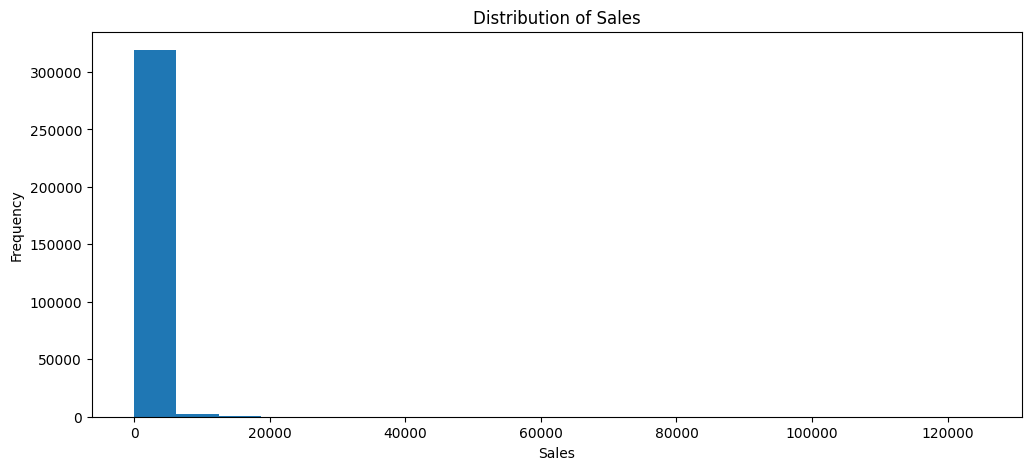

In [36]:
# Create a figure and two subplots side by side
fig, (ax1) = plt.subplots(1, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(finaledadata['sales'], bins=20)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sales')

##### 2. Transcations

In [37]:
finaledadata['transactions'].describe()

count    322047.000000
mean       1734.117840
std        1050.335018
min          54.000000
25%        1030.000000
50%        1409.000000
75%        2148.000000
max        8359.000000
Name: transactions, dtype: float64

Text(0.5, 1.0, 'Distribution of Transactions')

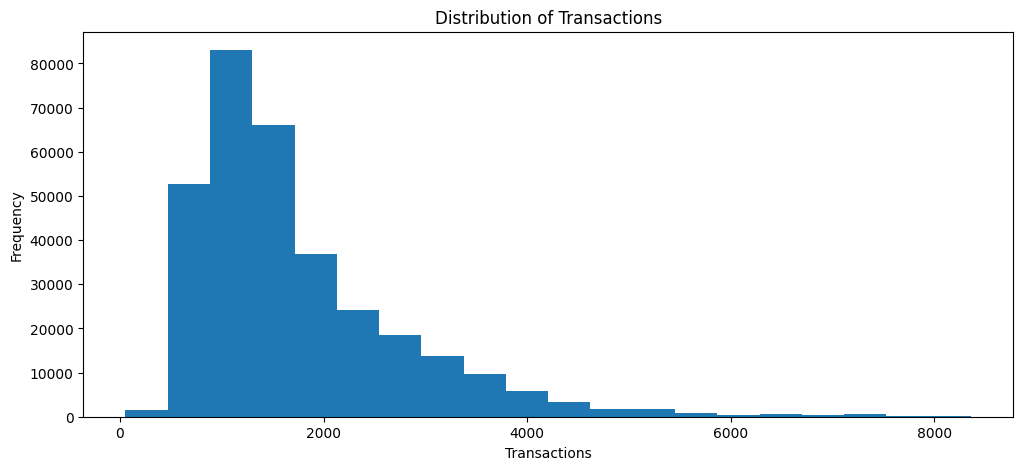

In [38]:
# Create a figure and two subplots side by side
fig, (ax1) = plt.subplots(1, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(finaledadata['transactions'], bins=20)
ax1.set_xlabel('Transactions')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Transactions')

##### 3. Oil

In [39]:
finaledadata['oil_price'].describe()

count    322047.000000
mean         63.636381
std          24.855753
min          27.959999
25%          44.880001
50%          51.980000
75%          94.089996
max         107.949997
Name: oil_price, dtype: float64

Text(0.5, 1.0, 'Distribution of Oil Price')

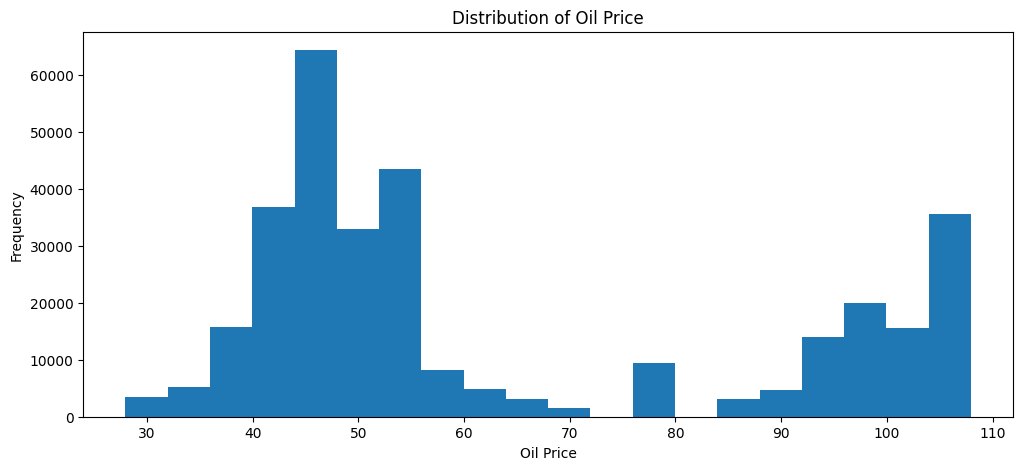

In [40]:
# Create a figure and two subplots side by side
fig, (ax1) = plt.subplots(1, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(finaledadata['oil_price'], bins=20)
ax1.set_xlabel('Oil Price')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Oil Price')

##### 4. Promotion

In [41]:
finaledadata['onpromotion'].describe()

count    322047.000000
mean          3.727136
std          15.512095
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         716.000000
Name: onpromotion, dtype: float64

Text(0.5, 1.0, 'Distribution of Promotions')

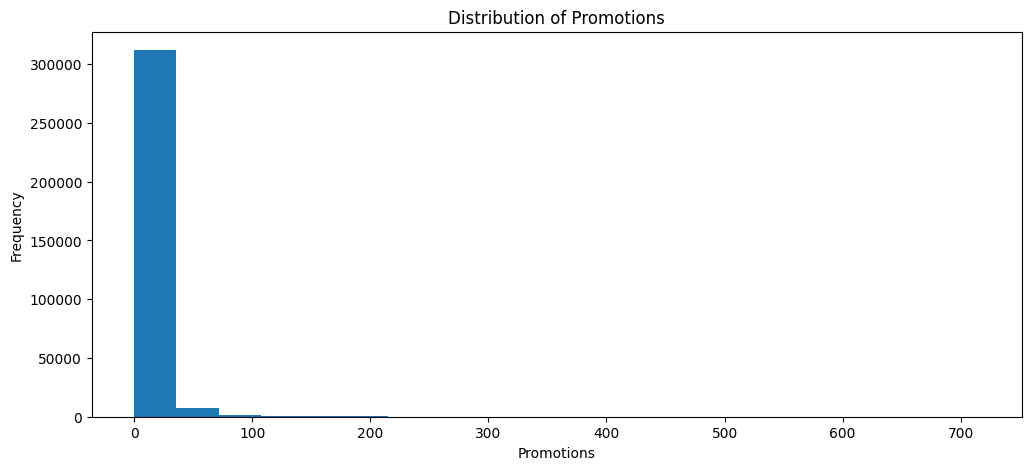

In [42]:
# Create a figure and two subplots side by side
fig, (ax1) = plt.subplots(1, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(finaledadata['onpromotion'], bins=20)
ax1.set_xlabel('Promotions')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Promotions')

### Bivariate Analysis

##### 1. Count of sales by store type

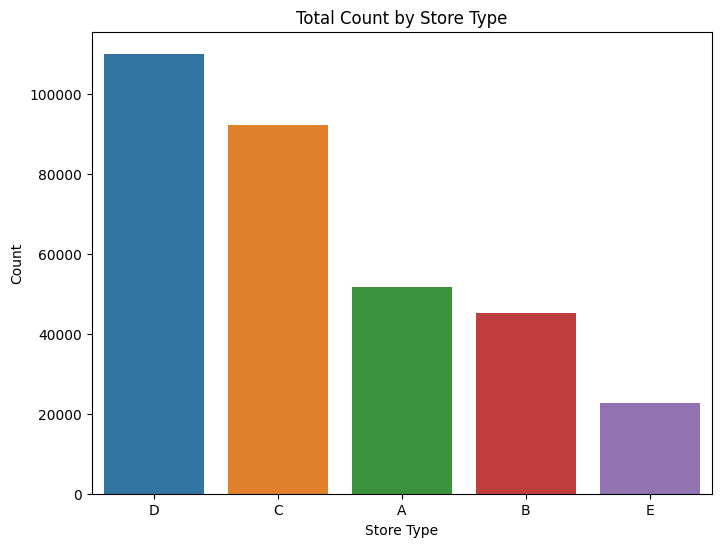

In [43]:
# Calculate the total count and total sales per store type
store_type_counts = finaledadata['store_type'].value_counts()
store_type_sales = finaledadata.groupby('store_type')['sales'].sum()

# Create a bar plot with "viridis" color palette for total count
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values)
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Type')
plt.show()

From the bar plot, we can see that store type D has the highest sales type compared to the other store types in the dataset. This means that, store type D performs better in terms of sales compared to store types A, B, C, E.

##### 2. Average sales by city

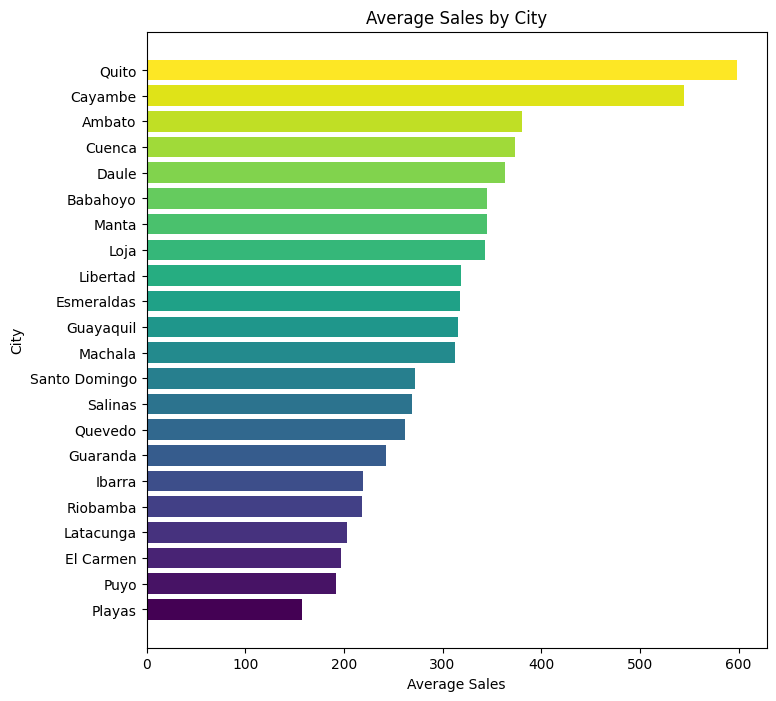

In [44]:
# Group by city and calculate the average sales
average_sales_by_city = finaledadata.groupby('city')['sales'].mean()

# Sort the data by average sales in ascending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Define colors for the bar plot using 'viridis' color palette
colors = cm.viridis(np.linspace(0, 1, len(average_sales_by_city)))

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

From the bar plot, we can see that Quito city has the highest average sales compared to the other city in the dataset. This means that, on average, Quito city performs better in terms of sales compared to any other city that we have in chart.  It indicates that Quito city is potentially the most successful or popular city in Favorita.

##### 3. Trend of sales over time

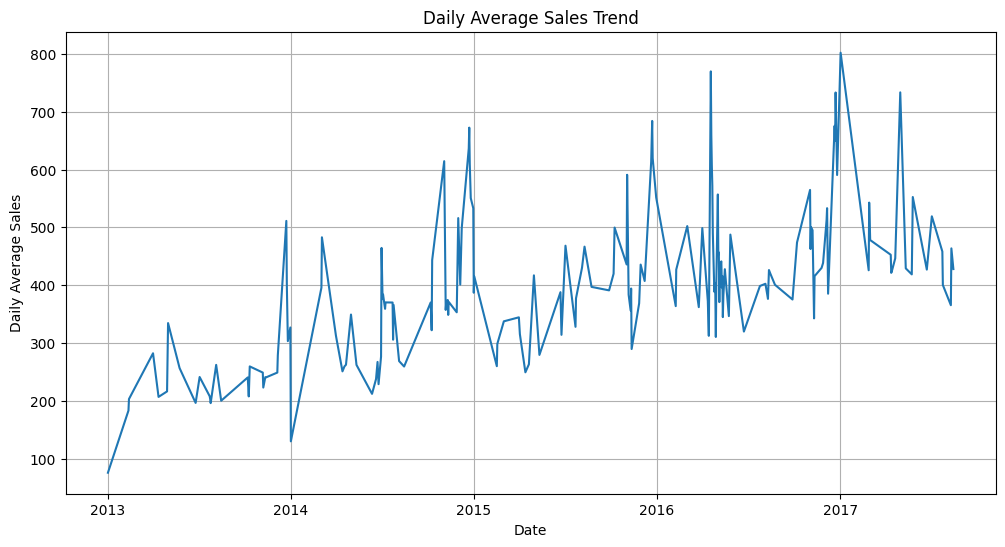

In [45]:
# Convert 'date' column to datetime format (if not already done)
finaledadata['date'] = pd.to_datetime(finaledadata['date'])

# Group the data by date and calculate the daily average sales
daily_avg_sales = finaledadata.groupby('date')['sales'].mean()

# Plot the daily average sales trend
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_sales.index, daily_avg_sales.values)
plt.xlabel('Date')
plt.ylabel('Daily Average Sales')
plt.title('Daily Average Sales Trend')
plt.grid(True)
plt.show()

We can observe that there is a yearly seasonality in sales where data tend to increase at the beginning of each year and then decrease as the year progresses. This pattern suggests that there might be some seasonal factors influencing the sales behavior, and the sales trend repeats annually.

##### 4. Average sales by state

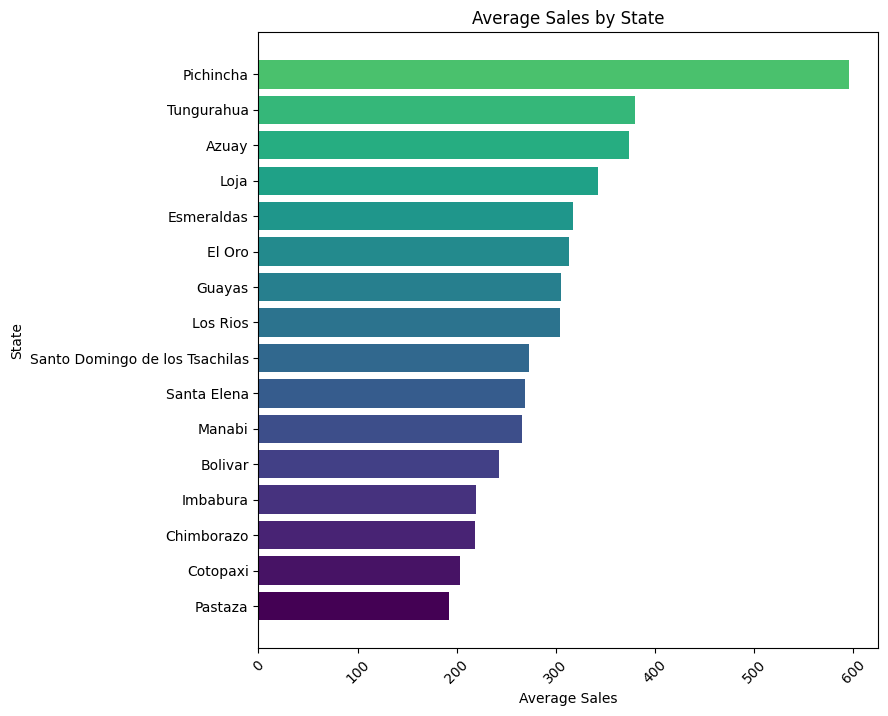

In [46]:
# Group by state and calculate the average sales
average_sales_by_state = finaledadata.groupby('state')['sales'].mean()

# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

From the bar plot, we can see that Pichincha state has the highest average sales compared to the other city in the dataset. This means that, on average, Pichincha state performs better in terms of sales compared to any other states.

##### 5. compare Sales on Holidays and Non Holidays

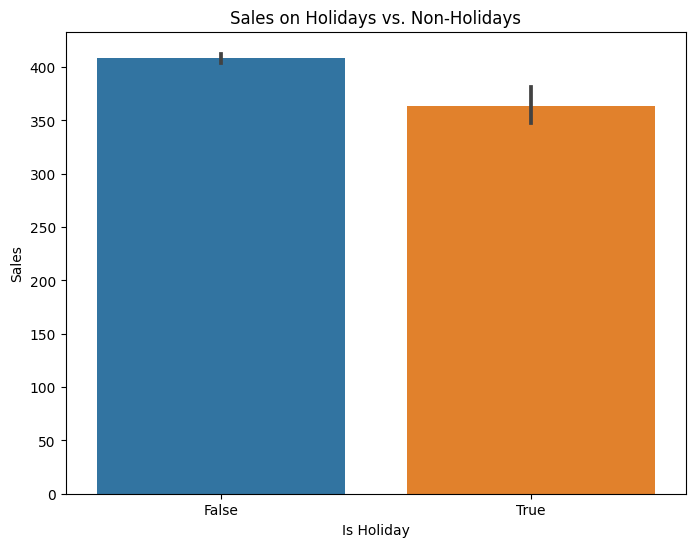

In [47]:
# Bar plot to compare sales on holidays and non-holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='transferred', y='sales', data=finaledadata)
plt.title('Sales on Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()

The bar plot comparing sales on holidays and non-holidays shows that sales are generally lower on holidays (transferred=True) compared to non-holidays (transferred=False). This suggests that there might be a negative impact on sales during holidays, possibly due to store closures or reduced consumer activity

##### 6. Sales Variation with On Promotion
We can analyze whether sales are significantly affected by promotional offers. A bar plot can show the average sales for items on promotion and not on promotion.

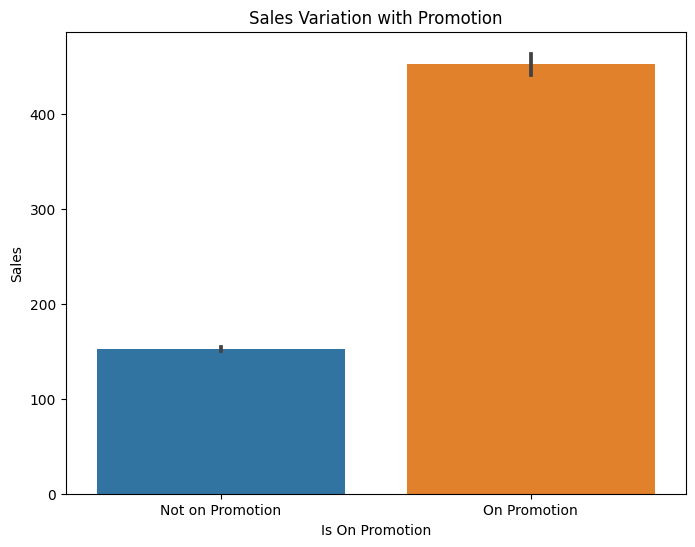

In [48]:
# Map the numeric onpromotion values to meaningful labels
onpromotion_mapping = {0: 'Not on Promotion', 1: 'On Promotion'}
finaledadata['onpromotion'] = finaledadata['onpromotion'].map(onpromotion_mapping)

# Create the bar plot with labels
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='sales', data=finaledadata)
plt.title('Sales Variation with Promotion')
plt.xlabel('Is On Promotion')
plt.ylabel('Sales')
plt.show()

The bar plot comparing sales variation on promotion and not on promotion shows that sales are generally higher on promotion compared to not on promotion . This suggests that there might be a negative impact on sales if there are no promotional activities.

### Multivaratiate Analysis

##### 1. Sales on Holidays By Store Type

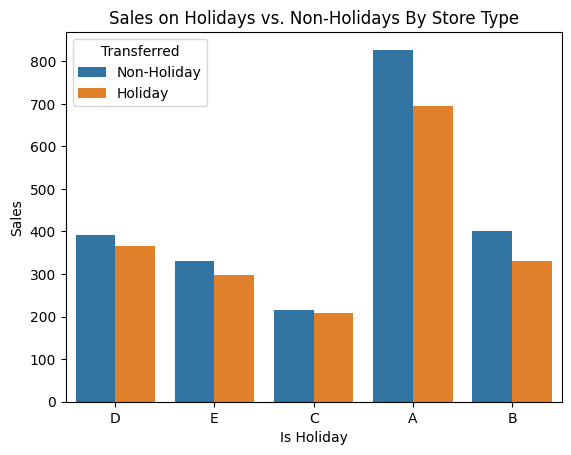

In [49]:
sns.barplot(x='store_type', y='sales', hue='transferred', data=finaledadata, ci=None)
plt.title('Sales on Holidays vs. Non-Holidays By Store Type')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.legend(title='Transferred', labels=['Non-Holiday', 'Holiday'])
plt.show()

The bar plot clearly illustrates that store type A exhibits the highest sales compared to the other store types in the dataset. This suggests that, store type A outperforms store types B, C, and any other potential types present in the dataset even on Holidays

##### 2. Correlation Matrix of numerical variable

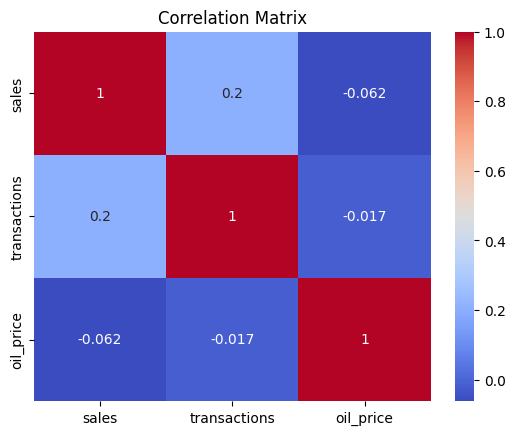

In [50]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'oil_price']

# Compute correlation matrix
corr_matrix = finaledadata[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Hypothesis

Null Hypothesis: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternate Hypothesis: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Test for promotional activities

In [51]:
# Prepare the independent variable (promotional activities)
onpromotion = finaldata['onpromotion']

# Prepare the dependent variable (store sales)
sales = finaldata['sales']

# Perform the t-test for promotional activities on store sales
t_stat, p_value = stats.ttest_ind(sales[onpromotion == 1], sales[onpromotion == 0], equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Check the p-value to determine the significance
alpha = 0.05
if p_value < alpha:
    print("Promotional activities have a significant impact on store sales.")
else:
    print("Promotional activities do not have a significant impact on store sales.")

P-value: 0.0
Promotional activities have a significant impact on store sales.


Test for Oil prices

In [52]:

# Prepare the independent variable (oil prices)
dcoilwtico = finaldata['oil_price']

# Perform the t-test for oil prices on store sales
t_stat, p_value = stats.ttest_ind(sales[dcoilwtico > 0], sales[dcoilwtico <= 0], equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Check the p-value to determine the significance
alpha = 0.05
if p_value < alpha:
    print("Oil prices have a significant impact on store sales.")
else:
    print("Oil prices do not have a significant impact on store sales.")

P-value: nan
Oil prices do not have a significant impact on store sales.


Test for Holidays/Events

In [53]:
# Prepare the independent variable (holidays/events)
holiday_type = finaldata['holiday_type']

# Perform the t-test for holidays/events on store sales
holiday_sales = sales[holiday_type != 'None']
non_holiday_sales = sales[holiday_type == 'None']
t_stat, p_value = stats.ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Check the p-value to determine the significance
alpha = 0.05
if p_value < alpha:
    print("Holidays/Events have a significant impact on store sales.")
else:
    print("Holidays/Events do not have a significant impact on store sales.")

P-value: nan
Holidays/Events do not have a significant impact on store sales.


### Answering analystical questions

In [54]:
# First, we create a copy of the original data to maintain the integrity of the original data as we embark on answering our questions

finalansdata = finaldata.copy()

1. Which Month had the lowest and highest sales for each year?

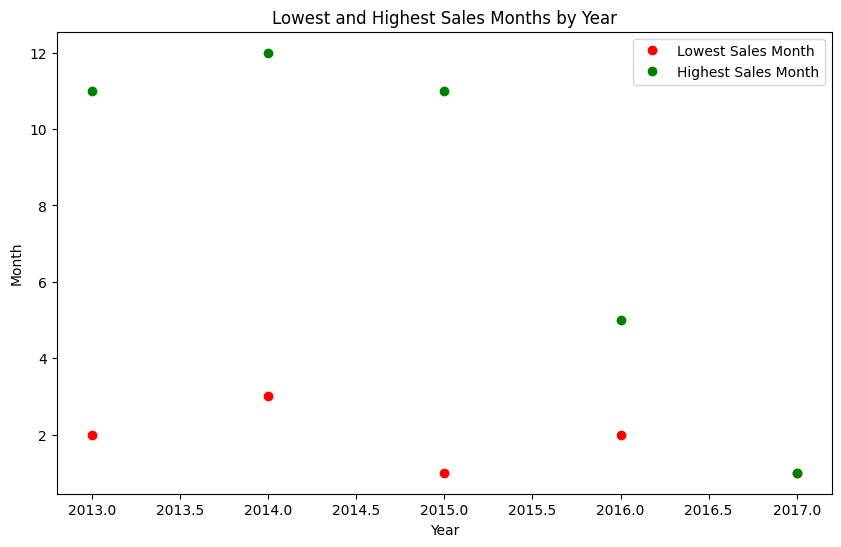

In [55]:
# Extract the year and month from the 'date' column
finalansdata['year'] = finalansdata['date'].dt.year
finalansdata['month'] = finalansdata['date'].dt.month

# Find the month with the lowest and highest sales for each year
lowest_sales_month = finalansdata.groupby(['year'])['sales'].idxmin()
highest_sales_month = finalansdata.groupby(['year'])['sales'].idxmax()

fig, ax = plt.subplots(figsize=(10, 6)) # Create a figure and axes for the plot

# Plot the lowest sales month
ax.plot(finalansdata.loc[lowest_sales_month, 'year'], finalansdata.loc[lowest_sales_month, 'month'], marker='o', linestyle='', color='red', label='Lowest Sales Month')

# Plot the highest sales month
ax.plot(finalansdata.loc[highest_sales_month, 'year'], finalansdata.loc[highest_sales_month, 'month'], marker='o', linestyle='', color='green', label='Highest Sales Month')

ax.set_xlabel('Year') # Set the x-axis label

ax.set_ylabel('Month') # Set the y-axis label

ax.set_title('Lowest and Highest Sales Months by Year') # Set the title

ax.legend() # Add a legend

plt.show() # Show the plot


2. Which 5 Cities had the highest sales for each year

In [56]:
finalansdata['state'].unique()

array(['Pichincha', 'El Oro', 'Esmeraldas', 'Guayas', 'Azuay', 'Loja',
       'Manabi', 'Tungurahua', 'Santo Domingo de los Tsachilas',
       'Los Rios', 'Bolivar', 'Imbabura', 'Cotopaxi', 'Chimborazo',
       'Santa Elena', 'Pastaza'], dtype=object)

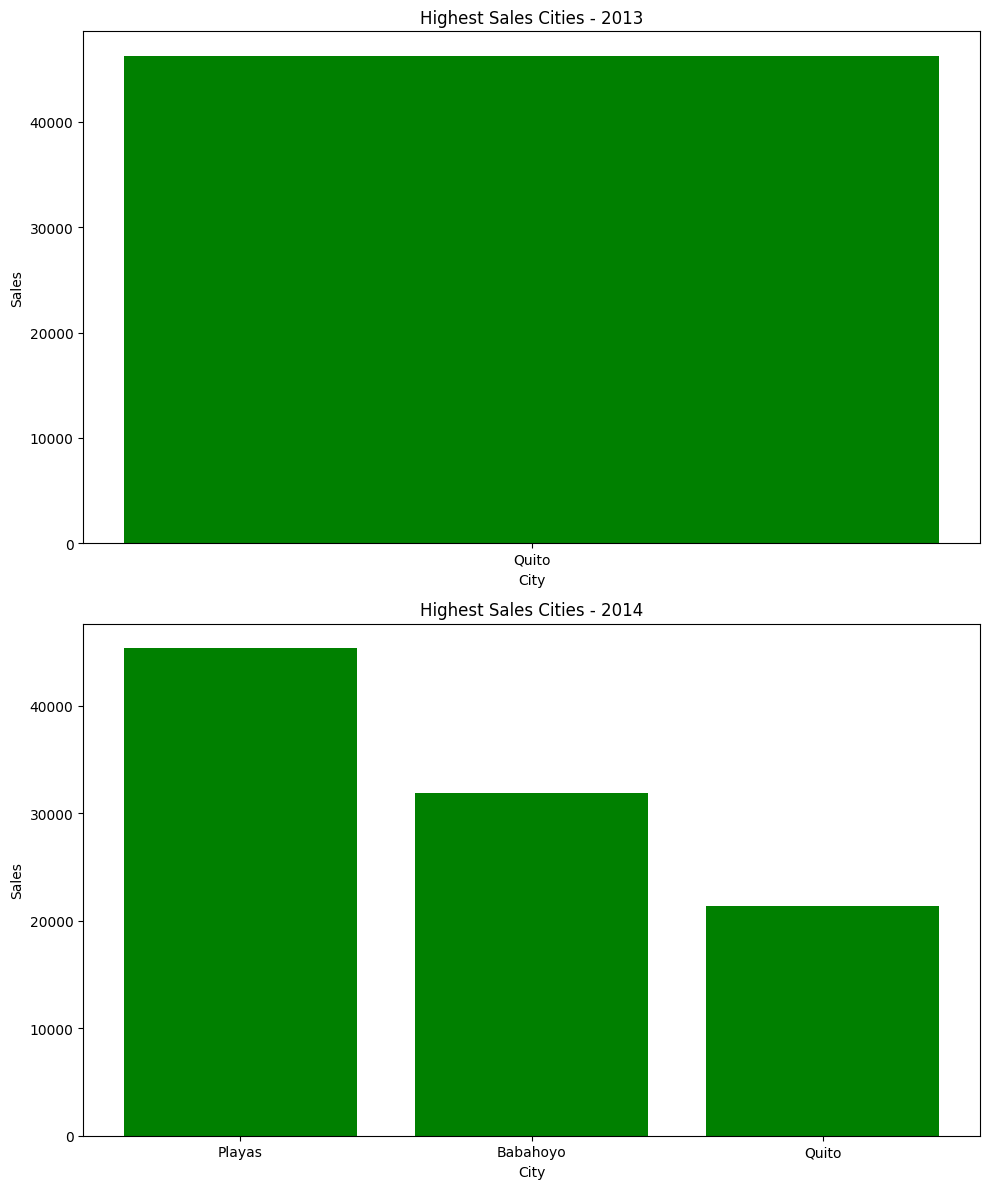

In [57]:
# Find the 5 cities with the highest and lowest sales for each year
finalansdata['rank_high'] = finalansdata.groupby(['year'])['sales'].rank(ascending=False)

highest_cities = finalansdata[finalansdata['rank_high'] <= 5]

# Create a figure and axes for the plot
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot cities with the highest sales
for year, ax in zip(highest_cities['year'].unique(), axes):
    data_year = highest_cities[highest_cities['year'] == year]
    ax.bar(data_year['city'], data_year['sales'], color='green')
    ax.set_title(f'Highest Sales Cities - {year}')
    ax.set_xlabel('City')
    ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()


3. Which year had the highest and lowest transactions made?

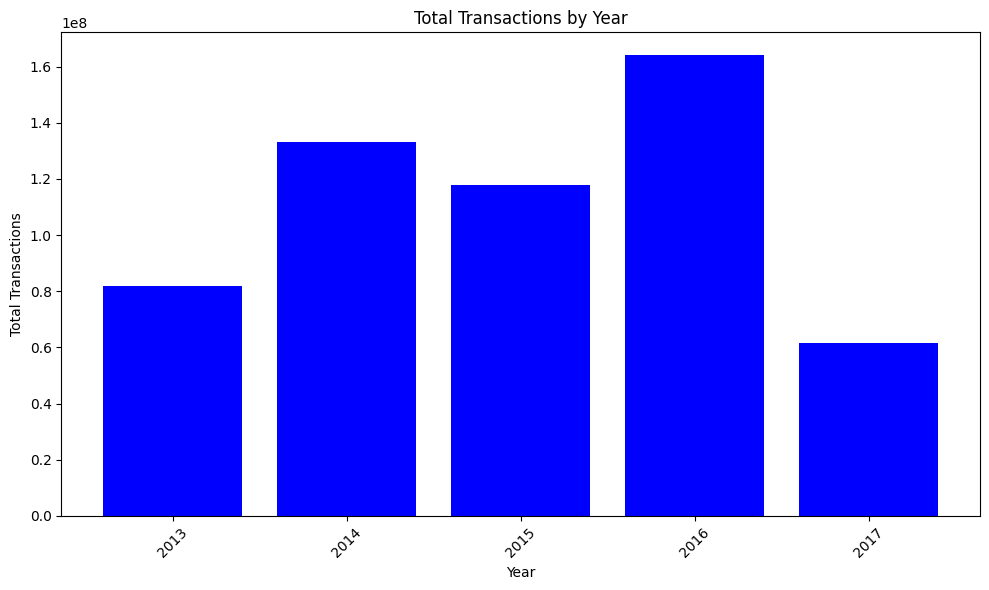

In [58]:
# Group by year and calculate the sum of transactions
yearly_transactions = finalansdata.groupby('year')['transactions'].sum()

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the total transactions for each year
ax.bar(yearly_transactions.index, yearly_transactions.values, color='blue')

ax.set_title('Total Transactions by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Total Transactions')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


4. Which store has the highest average sales, and which one has the lowest for each year?

In [59]:
finalansdata['store_nbr'].unique()

array([ 1., 41., 43., 40.,  4., 45., 44., 46., 35., 37., 34., 39., 38.,
       54.,  6.,  9.,  8.,  7., 48., 49., 47., 51., 50.,  5., 33., 18.,
       17., 19., 16., 15.,  2., 11., 10., 12., 14., 13.,  3., 30., 28.,
       32., 31., 23., 24., 27., 26., 25., 36., 53., 20., 29., 21., 42.,
       22., 52.])

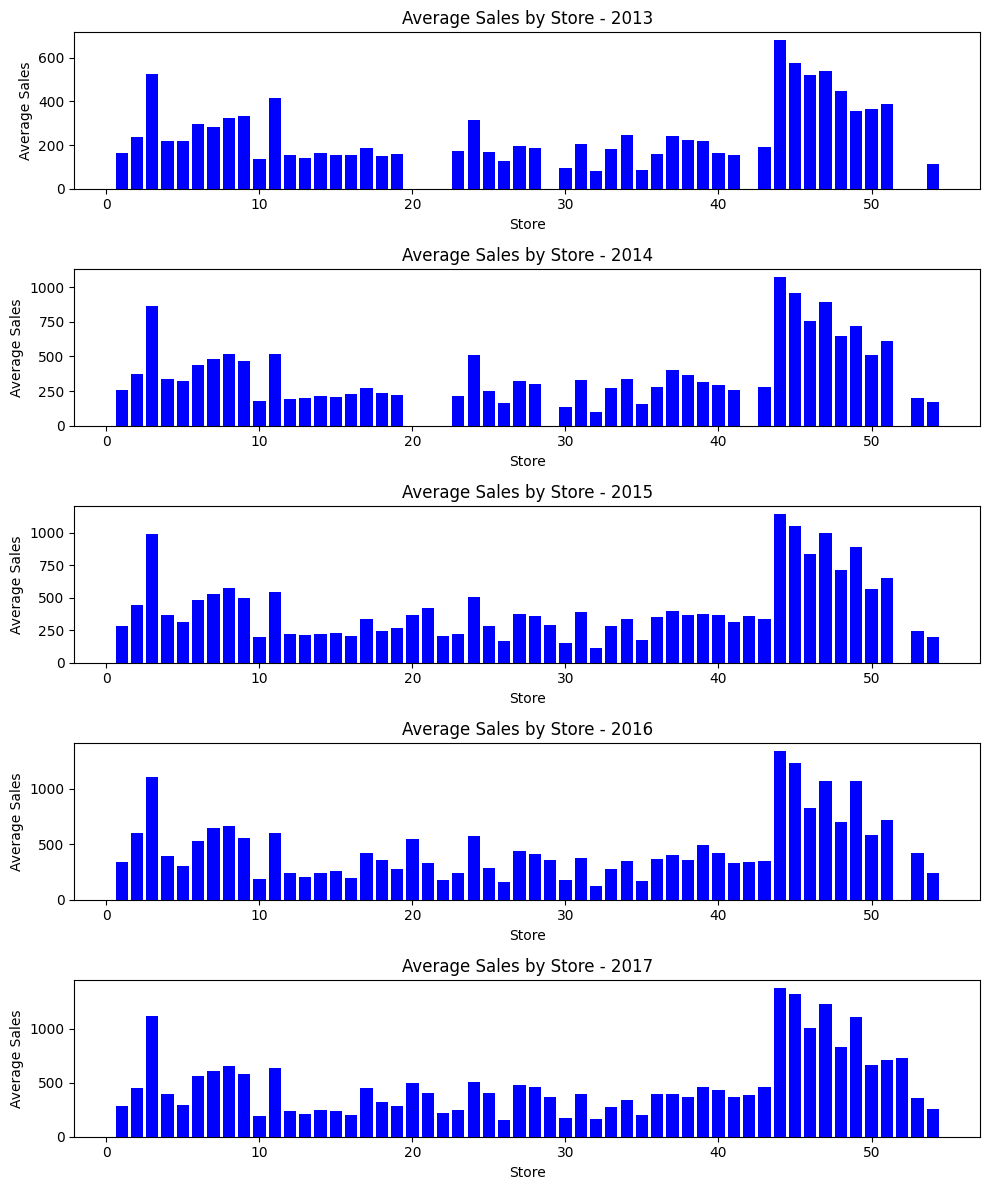

In [60]:
# Group by year and store, calculate the average sales
yearly_avg_sales = finalansdata.groupby(['year', 'store_nbr'])['sales'].mean().reset_index()

# Find the store with the highest and lowest average sales for each year
highest_avg_sales = yearly_avg_sales.groupby('year')['sales'].idxmax()
lowest_avg_sales = yearly_avg_sales.groupby('year')['sales'].idxmin()

# Create a figure and axes for the plot
fig, axes = plt.subplots(len(yearly_avg_sales['year'].unique()), 1, figsize=(10, 12))

for i, year in enumerate(yearly_avg_sales['year'].unique()):
    data_year = yearly_avg_sales[yearly_avg_sales['year'] == year]
    ax = axes[i]
    ax.bar(data_year['store_nbr'], data_year['sales'], color='blue')
    ax.set_title(f'Average Sales by Store - {year}')
    ax.set_xlabel('Store')
    ax.set_ylabel('Average Sales')

plt.tight_layout()
plt.show()


6. What is the relationship between oil prices and sales? 

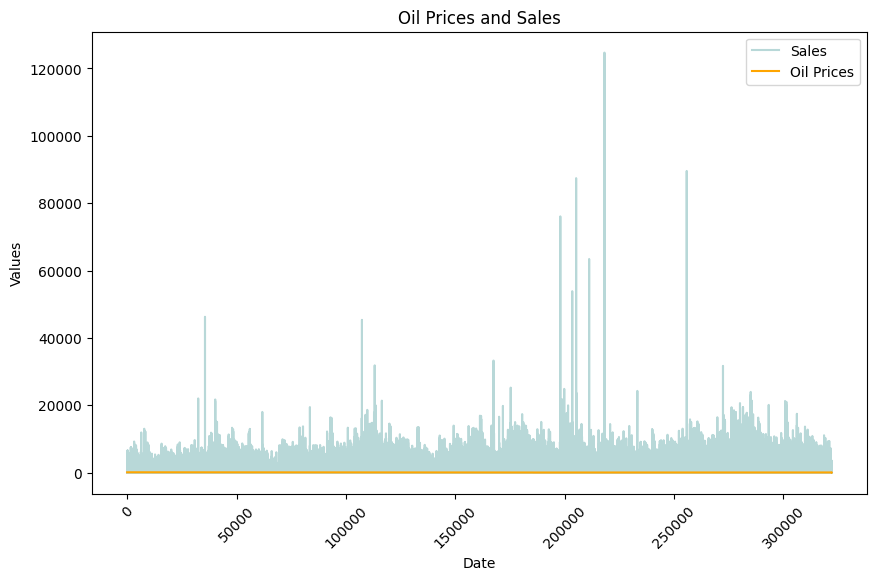

In [61]:
# oil prices and sales
plt.figure(figsize=(10, 6))

# Plot sales
plt.plot(finalansdata.index, finalansdata['sales'], label='Sales', color='#B8D8D8')  # Soft blue color

# Plot oil prices
plt.plot(finalansdata.index, finalansdata['oil_price'], label='Oil Prices', color='orange')

plt.title('Oil Prices and Sales')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Feature engineering and feature scaling

In [62]:
# Overview of the data
finaldata.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,oil_price
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [63]:
# Checking for duplicates
finaldata.duplicated().sum()

0

In [64]:
#change date datatype as datetime to create new features

finaldata.date = pd.to_datetime(finaldata.date)

finaldata['year'] = finaldata.date.dt.year

finaldata['month'] = finaldata.date.dt.month

finaldata['dayofmonth'] = finaldata.date.dt.day

finaldata['dayofweek'] = finaldata.date.dt.dayofweek

finaldata.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,oil_price,year,month,dayofmonth,dayofweek
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0


In [65]:
finaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  float64       
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  float64       
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  float64       
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   store_type    322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  holiday_type  322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [66]:
#drop unnecessary columns
finaldata.drop(columns=['id','locale', 'locale_name', 'description', 'transferred', 'state',  'store_type'], inplace=True)

In [67]:
# set the date column as the index
finaldata.set_index('date', inplace=True)

In [68]:
finaldata.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,oil_price,year,month,dayofmonth,dayofweek
date,,,,,,,,,,,,,
2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0


In [69]:

final_data = finaldata.copy()

##### Features Encoding

In [70]:
# Select the categorical columns
categorical_columns = ["family", "city", "holiday_type"]
categorical_data = final_data[categorical_columns]
columns = list(final_data.columns)
print(columns)

['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'cluster', 'transactions', 'holiday_type', 'oil_price', 'year', 'month', 'dayofmonth', 'dayofweek']


In [71]:
numerical_columns = [i for i in columns if i not in categorical_columns]

In [72]:
numerical_columns.remove('sales')
print(numerical_columns)

['store_nbr', 'onpromotion', 'cluster', 'transactions', 'oil_price', 'year', 'month', 'dayofmonth', 'dayofweek']


In [73]:
# Instantiate a BinaryEncoder transformer
encoder = BinaryEncoder(drop_invariant=False, return_df=True,)

# Apply the encoder on the categorical data
binary_encoded = encoder.fit(final_data[categorical_columns])

binary_encoded


BinaryEncoder(cols=['family', 'city', 'holiday_type'],
              mapping=[{'col': 'family',
                        'mapping':      family_0  family_1  family_2  family_3  family_4  family_5
 1          0         0         0         0         0         1
 2          0         0         0         0         1         0
 3          0         0         0         0         1         1
 4          0         0         0         1         0         0
 5          0         0         0         1         0         1
 6          0         0         0         1         1         0
 7          0         0         0         1         1         1
 8          0         0         1         0         0         0
 9          0         0         1         0         0         1
 10         0         0         1         0         1         0
 11         0         0         1         0         1         1
 12         0         0         1         1         0         0
 13         0         0         1         1         0         1
 14         0         0         1         1         1         0
 15         0         0         1         1         1         1
 16         0         1         0         0         0         0
 17         0         1         0         0         0         1
 18         0         1         0         0         1         0
 19         0         1         0         0         1         1
 20         0         1         0         1         0         0
 21         0         1         0         1         0         1
 22         0         1         0         1         1         0
 23         0         1         0         1         1         1
 24         0         1         1         0         0         0
 25         0         1         1         0         0         1
 26         0         1         1         0         1         0
 27         0         1         1         0         1         1
 28         0         1         1         1         0         0...
 32         1         0         0         0         0         0
 33         1         0         0         0         0         1
-1          0         0         0         0         0         0
-2          0         0         0         0         0         0},
                       {'col': 'city',
                        'mapping':      city_0  city_1  city_2  city_3  city_4
 1        0       0       0       0       1
 2        0       0       0       1       0
 3        0       0       0       1       1
 4        0       0       1       0       0
 5        0       0       1       0       1
 6        0       0       1       1       0
 7        0       0       1       1       1
 8        0       1       0       0       0
 9        0       1       0       0       1
 10       0       1       0       1       0
 11       0       1       0       1       1
 12       0       1       1       0       0
 13       0       1       1       0       1
 14       0       1       1       1       0
 15       0       1       1       1       1
 16       1       0       0       0       0
 17       1       0       0       0       1
 18       1       0       0       1       0
 19       1       0       0       1       1
 20       1       0       1       0       0
 21       1       0       1       0       1
 22       1       0       1       1       0
-1        0       0       0       0       0
-2        0       0       0       0       0},
                       {'col': 'holiday_type',
                        'mapping':     holiday_type_0  holiday_type_1  holiday_type_2
 1               0               0               1
 2               0               1               0
 3               0               1               1
 4               1               0               0
 5               1               0               1
-1               0               0               0
-2               0               0               0}])

Feature Scaling

In [74]:
final_data[numerical_columns].head()

,store_nbr,onpromotion,cluster,transactions,oil_price,year,month,dayofmonth,dayofweek
date,,,,,,,,,
2013-02-11,1.0,0.0,13,396,97.010002,2013,2,11,0
2013-02-11,1.0,0.0,13,396,97.010002,2013,2,11,0
2013-02-11,1.0,0.0,13,396,97.010002,2013,2,11,0
2013-02-11,1.0,0.0,13,396,97.010002,2013,2,11,0
2013-02-11,1.0,0.0,13,396,97.010002,2013,2,11,0


In [75]:
# create an instance of StandardScaler
scaler = StandardScaler()

scaler.set_output(transform="pandas")

# fit and transform the numerical columns
scale_nums = scaler.fit(final_data[numerical_columns])
scale_nums

StandardScaler()

In [76]:
# transform the numerical and categorical columns
scale_nums = scaler.transform(final_data[numerical_columns])
binary_encoded = encoder.transform(final_data[categorical_columns])

In [77]:

final_data_encoded = pd.concat([scale_nums, binary_encoded, final_data.sales], axis=1)
final_data_encoded.head()

,store_nbr,onpromotion,cluster,transactions,oil_price,year,month,dayofmonth,dayofweek,family_0,...,family_5,city_0,city_1,city_2,city_3,city_4,holiday_type_0,holiday_type_1,holiday_type_2,sales
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.40364,-1.336086,0,...,1,0,0,0,0,1,0,0,1,0.0
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.40364,-1.336086,0,...,0,0,0,0,0,1,0,0,1,0.0
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.40364,-1.336086,0,...,1,0,0,0,0,1,0,0,1,21.0
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.40364,-1.336086,0,...,0,0,0,0,0,1,0,0,1,0.0
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.40364,-1.336086,0,...,1,0,0,0,0,1,0,0,1,3.0


Data Splitting

In [78]:
# Make a copy of the final_data_encoded as data
onedata = final_data_encoded.copy()
onedata

,store_nbr,onpromotion,cluster,transactions,oil_price,year,month,dayofmonth,dayofweek,family_0,...,family_5,city_0,city_1,city_2,city_3,city_4,holiday_type_0,holiday_type_1,holiday_type_2,sales
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.403640,-1.336086,0,...,1,0,0,0,0,1,0,0,1,0.00000
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.403640,-1.336086,0,...,0,0,0,0,0,1,0,0,1,0.00000
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.403640,-1.336086,0,...,1,0,0,0,0,1,0,0,1,21.00000
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.403640,-1.336086,0,...,0,0,0,0,0,1,0,0,1,0.00000
2013-02-11,-1.666843,-0.240273,0.948024,-1.273993,1.342694,-1.613649,-1.662104,-0.403640,-1.336086,0,...,1,0,0,0,0,1,0,0,1,3.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01,-0.127903,-0.240273,-1.597692,0.445461,-0.439190,-0.018471,-1.970502,-1.491163,0.672159,0,...,0,1,0,0,1,1,0,0,1,0.00000
2015-01-01,-0.127903,-0.240273,-1.597692,0.445461,-0.439190,-0.018471,-1.970502,-1.491163,0.672159,0,...,1,1,0,0,1,1,0,0,1,105.00000
2015-01-01,-0.127903,-0.240273,-1.597692,0.445461,-0.439190,-0.018471,-1.970502,-1.491163,0.672159,1,...,0,1,0,0,1,1,0,0,1,121.94100


In [79]:
# Create the feature dataframe using the selected columns
X = onedata.drop(["sales"], axis=1)

# Get the target variable
y = onedata.sales

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:

#cross checking for null values in the test dataset 

X_test.isnull().sum()

store_nbr         0
onpromotion       0
cluster           0
transactions      0
oil_price         0
year              0
month             0
dayofmonth        0
dayofweek         0
family_0          0
family_1          0
family_2          0
family_3          0
family_4          0
family_5          0
city_0            0
city_1            0
city_2            0
city_3            0
city_4            0
holiday_type_0    0
holiday_type_1    0
holiday_type_2    0
dtype: int64

### Decision Tree Regression Model

Train the Model

In [81]:
# Decision Tree Regression Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Make prediction on X_test
dt_pred = dt.predict(X_test)

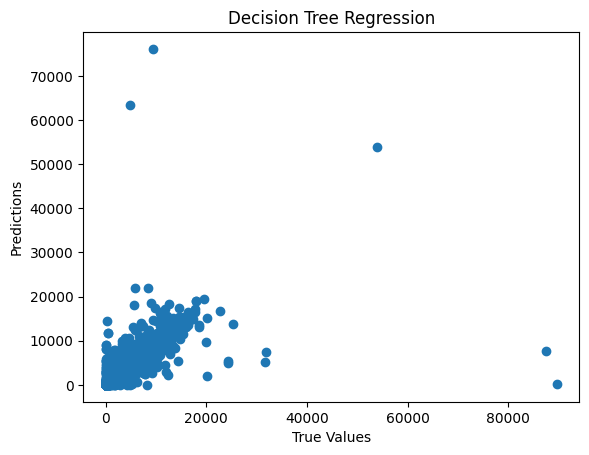

In [82]:
plt.scatter(y_test, dt_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Decision Tree Regression")
plt.show()

Decision Tree Regression evaluation metrics

In [83]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
dt_pred_abs = abs(dt_pred)

In [84]:
# Evaluate our models
mse = mean_squared_error(y_test, dt_pred)
msle = mean_squared_log_error(y_test_abs, dt_pred_abs)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt((msle)).round(2)

dt_results = pd.DataFrame([['Decision Tree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
dt_results

,Model,MSE,MSLE,RMSE,RMSLE
0,Decision Tree,516767.791808,0.343983,718.87,0.59


### XGBoost Model

In [85]:
# XGBoost Model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

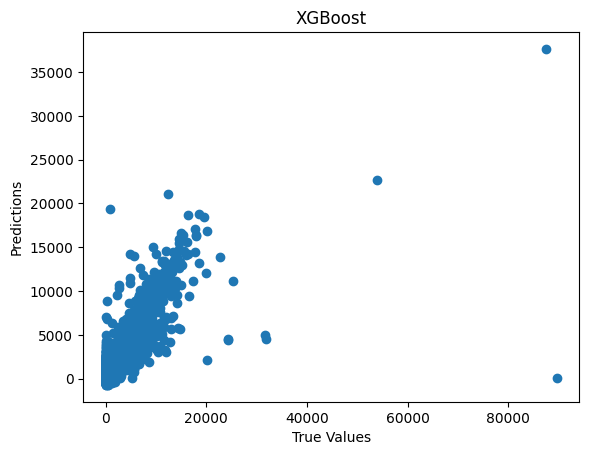

In [86]:
plt.scatter(y_test, xgb_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("XGBoost")
plt.show()

Evaluate of XGBoast Model

In [87]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
xgb_pred_abs = abs(xgb_pred)

In [88]:
# Evaluate our models
mse = mean_squared_error(y_test, xgb_pred)
msle = mean_squared_log_error(y_test_abs, xgb_pred_abs)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(2)


# Create a DataFrame for the current model's results
model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]], columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

# Display the results DataFrame
model_results

,Model,MSE,MSLE,RMSE,RMSLE
0,XGBoost,392671.116643,6.040951,626.63,2.46


### Linear Regression Model

In [89]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make prediction on X_test
lr_pred = lr.predict(X_test)

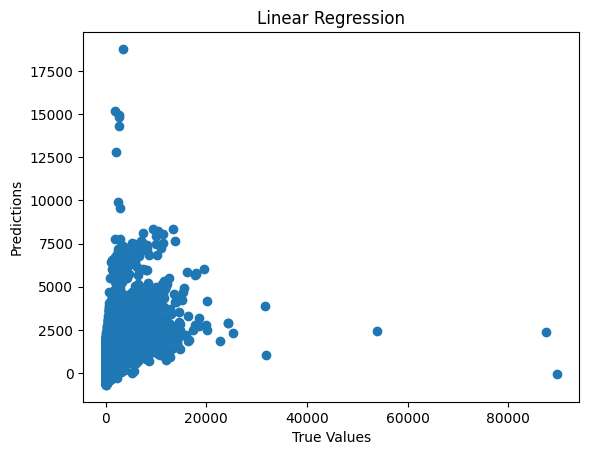

In [90]:
plt.scatter(y_test, lr_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression")
plt.show()

Evaluation Metrics for Linear Regression

In [91]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
lr_pred_abs = abs(lr_pred)

In [92]:
# Evaluate our models
mse = mean_squared_error(y_test, lr_pred)
msle = mean_squared_log_error(y_test_abs, lr_pred_abs)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(2)

lr_results = pd.DataFrame([['Linear Regression', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
lr_results

,Model,MSE,MSLE,RMSE,RMSLE
0,Linear Regression,1.244209e+06,11.881793,1115.44,3.45


### Random Forest Regression Model

In [93]:
# Random Forest Regression Model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Make prediction on X_test
rf_pred = rf.predict(X_test)

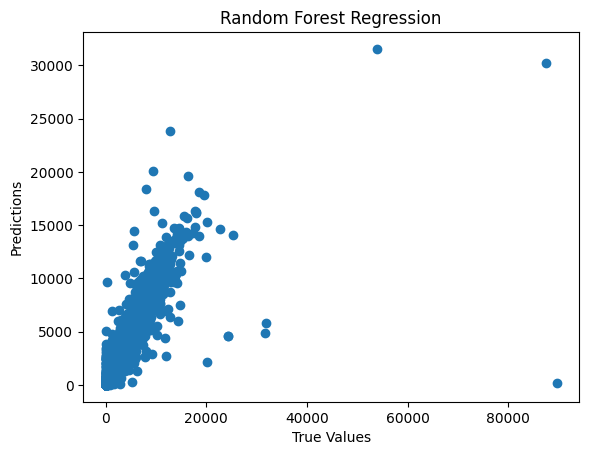

In [94]:
plt.scatter(y_test, rf_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Random Forest Regression")
plt.show()

In [95]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
rf_pred_abs = abs(rf_pred)

In [96]:
# Evaluate our models
mse = mean_squared_error(y_test, rf_pred)
msle = mean_squared_log_error(y_test_abs, rf_pred_abs)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(2)

rf_results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
rf_results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,296371.023701,0.274548,544.4,0.52


Data overview

In [97]:
print(dt_results)
print(model_results)
print(lr_results)
print(rf_results)

           Model            MSE      MSLE    RMSE  RMSLE
0  Decision Tree  516767.791808  0.343983  718.87   0.59
     Model            MSE      MSLE    RMSE  RMSLE
0  XGBoost  392671.116643  6.040951  626.63   2.46
               Model           MSE       MSLE     RMSE  RMSLE
0  Linear Regression  1.244209e+06  11.881793  1115.44   3.45
           Model            MSE      MSLE   RMSE  RMSLE
0  Random Forest  296371.023701  0.274548  544.4   0.52


#### Testing for Stationarity

Stationarity can be determined using the following:

Autocorrelation Function(ACF) and Partial Autocorrelation Function(PACF) plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

Augmented Dickey-Fuller Test(ADF): This is one of the statistical tests for checking stationarity. The test result consists of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, it can be concluded that the series is stationary.

In [98]:
#Perform the ADF test
result = adfuller(finaldata['sales'])

#Extract the p-value from the test result
p_value = result[1]

#Check for stationarity based on the p-value
if p_value < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

The time series is stationary.


### Tunning our model - Random Forest

**Hyperparameter Tuning (GridSearchCV):**
- GridSearchCV is used to search for the best combination of hyperparameters from the provided parameter grid.
- It performs cross-validation to evaluate different combinations of hyperparameters and selects the best performing one based on the provided scoring metric (in this case, 'f1').
- The best parameters and best estimator are obtained from the `best_params_` and `best_estimator_` attributes of the GridSearchCV object.
- The best estimator is then used to make predictions on the test data.

In [99]:
# Define your hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
}

In [100]:
# Create the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)  # Adjust the number of splits as needed

In [101]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    rf, param_distributions=param_grid, n_iter=10, cv=tscv, scoring='neg_mean_squared_error'
)

# Fit the RandomizedSearchCV object on your training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_mean_squared_error')

In [102]:
# Get the best model
best_rf = random_search.best_estimator_

# Make prediction on X_test
tuned_pred = best_rf.predict(X_test)

# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
tuned_pred_abs = abs(tuned_pred)

# Evaluate on the validation set
mse = mean_squared_error(y_test, tuned_pred)
msle = mean_squared_log_error(y_test_abs, tuned_pred_abs)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(2)

final_results = pd.DataFrame([['Tunned Results', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
final_results

,Model,MSE,MSLE,RMSE,RMSLE
0,Tunned Results,372312.282914,3.384363,610.17,1.84


In [110]:
tuned_pred.shape

(64410,)

In [111]:
# Create a DataFrame to hold the test data and predictions
sample = pd.DataFrame(X_test, columns=X_test.columns)
sample['Sales'] = tuned_pred

# Print the first few rows of the combined DataFrame
sample.head()

,store_nbr,onpromotion,cluster,transactions,oil_price,year,month,dayofmonth,dayofweek,family_0,...,family_5,city_0,city_1,city_2,city_3,city_4,holiday_type_0,holiday_type_1,holiday_type_2,Sales
date,,,,,,,,,,,,,,,,,,,,,
2015-04-01,-1.474476,-0.240273,0.099452,-0.065806,-0.543794,-0.018471,-1.045309,-1.491163,0.002744,0,...,0,0,0,0,0,1,0,0,1,266.570705
2015-11-30,-1.346231,-0.240273,0.948024,0.122706,-0.933644,-0.018471,1.113473,1.662655,-1.336086,0,...,1,0,0,0,0,1,1,0,0,44.436851
2015-11-27,-0.705006,-0.240273,-1.173406,-1.003603,-0.928011,-0.018471,1.113473,1.336398,1.341573,0,...,1,0,1,0,1,0,1,0,0,5.146456
2016-05-12,0.192709,-0.175807,-1.173406,-0.976945,-0.683802,0.779118,-0.736912,-0.294887,0.672159,0,...,0,0,0,1,1,0,0,0,1,116.947299
2013-02-11,0.641567,-0.240273,-1.385549,-1.008363,1.342694,-1.613649,-1.662104,-0.403640,-1.336086,0,...,0,0,0,1,0,1,0,0,1,1.486825
